There's been a lot of buzz about **big data** over the last few years, and it's finally become mainstream. Companies like Google and Yahoo! have grown their user bases significantly, and are collecting more information on how people interact with their products. [Moore's law](https://en.wikipedia.org/wiki/Moore%27s_law) and the rapidly [falling cost of storage](https://www.aei.org/wp-content/uploads/2013/04/storage3_f.jpg) have contributed greatly to the big data phenomena.

While software companies got better at collecting massive amounts of data, their ability to analyze and make sense of it didn't keep pace. Because existing technologies couldn't analyze such large quantities of data, companies like Google, Facebook, Yahoo!, and LinkedIn had to build new paradigms and tools that could do the job.

Engineers initially tried using bigger and more powerful computers to process the data, but still ran into limits for many computational problems. Along the way, they developed paradigms like [MapReduce](https://en.wikipedia.org/wiki/MapReduce) that efficiently distribute calculations over hundreds or thousands of computers to calculate the result in parallel. Hadoop is an open source project that quickly became the dominant processing toolkit for big data.

**Hadoop**

Hadoop consists of a file system (Hadoop Distributed File System, or HDFS) and its own implementation of the MapReduce paradigm. MapReduce converts computations into Map and Reduce steps that Hadoop can easily distribute over many machines.

Hadoop made it possible to analyze large data sets, but relied heavily on disk storage (rather than memory) for computation. While it's inexpensive to store large volumes of data this way, it [makes accessing and processing it much slower](https://www.cnet.com/news/understanding-ram-versus-hard-drive-space-via-an-analogy/).

Hadoop wasn't a great solution for calculations requiring multiple passes over the same data or many intermediate steps, due to the need to write to and read from the disk between each step. This drawback also made Hadoop difficult to use for interactive data analysis, the main task data scientists need to do.

Hadoop also suffered from suboptimal support for the additional libraries many data scientists needed, such as SQL and machine learning implementations. Once the cost of RAM (computer memory) started to drop significantly, augmenting or replacing Hadoop by storing data in-memory quickly emerged as an appealing alternative.

The [UC Berkeley AMP Lab](https://amplab.cs.berkeley.edu/projects/spark-lightning-fast-cluster-computing/) spearheaded groundbreaking work to develop Spark, which uses distributed, in-memory data structures to improve speeds for many data processing workloads by several orders of magnitude. If we're interested in learning more, we can read about [why Spark is a crossover hit for data scientists](https://blog.cloudera.com/), or check out some of the original papers on the [Apache Spark homepage](http://spark.apache.org/research.html).

The core data structure in Spark is a resilient distributed data set (RDD). As the name suggests, an RDD is Spark's representation of a data set that's distributed across the RAM, or memory, of a cluster of many machines. An RDD object is essentially a collection of elements we can use to hold lists of tuples, dictionaries, lists, etc. Similar to a pandas DataFrame, we can load a data set into an RDD, and then run any of the methods accesible to that object.

**PySpark**

While the Spark toolkit is in Scala, a language that compiles down to bytecode for the JVM, the open source community has developed a wonderful toolkit called [PySpark](https://spark.apache.org/docs/0.9.0/python-programming-guide.html) that allows us to interface with RDDs in Python. Thanks to a library called [Py4J](https://github.com/bartdag/py4j), Python can interface with Java objects (in our case RDDs). Py4J is also one of the tools that makes PySpark work.

In this file, we'll work with a data set containing the names of all of the guests who have appeared on The [Daily Show](https://en.wikipedia.org/wiki/The_Daily_Show).

To start off, we'll load the data set into an RDD. We're using the TSV version of [FiveThirtyEight's data set](https://github.com/fivethirtyeight/data/tree/master/daily-show-guests). TSV files use a tab character ("\t") as the delimiter, instead of the comma (",") that CSV files use.

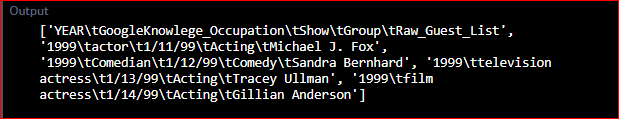

In Spark, the **SparkContext** object manages the connection to the clusters, and coordinates the running of processes on those clusters. More specifically, it connects to the cluster managers. The cluster managers control the executors that run the computations. Here's a diagram from the Spark documentation that will help us visualize the architecture:

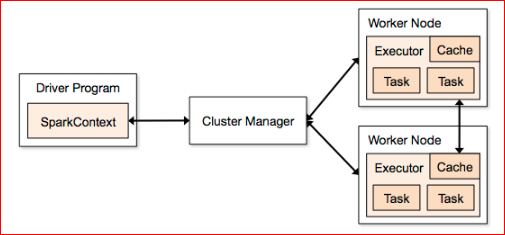

We automatically have access to the SparkContext object **sc**. We then run the following code to read the TSV data set into an RDD object raw_data:

**raw_data = sc.textFile("daily_show.tsv")**

The RDD object raw_data closely resembles a list of string objects, with one object for each line in the data set. We then use the take() method to print the first five elements of the RDD:

**raw_data.take(5)**

To explore the other methods an RDD object has access to, check out the [PySpark documentation](https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html#take) .take(n) will return the first n elements of the RDD.

We may be wondering why, if an RDD resembles a Python list, we don't just use bracket notation to access elements in the RDD.

The answer is that Spark distributes RDD objects across many partitions, and the RDD object is specifically designed to handle distributed data. We can't rely on the standard implementation of a list for these reasons.

Spark offers many advantages over regular Python, though. For example, thanks to RDD [abstraction](https://en.wikipedia.org/wiki/Abstraction_(computer_science)), we can run Spark locally on our own computer. Spark will simulate distributing our calculations over many machines by automatically slicing our computer's memory into partitions.

Spark's RDD implementation also lets us evaluate code "lazily," meaning we can postpone running a calculation until absolutely necessary. Above, Spark waited to load the TSV file into an RDD until raw_data.take(5) executed. When our code called raw_data = sc.textFile("dail_show.tsv"), Spark created a pointer to the file, but didn't actually read it into raw_data until raw_data.take(5) needed that variable to run its logic.

The advantage of "lazy" evaluation is that we can build up a queue of tasks and let Spark optimize the overall workflow in the background. In regular Python, the interpreter can't do much workflow optimization.

While Spark borrowed heavily from Hadoop's MapReduce pattern, it's still quite different in many ways. If we have experience with Hadoop and traditional MapReduce, we may want to read this great [post by Cloudera](https://blog.cloudera.com/) about the difference between them. Don't worry if we've never worked with MapReduce or Hadoop before; we'll cover the concepts we need to know.

The key idea to understand when working with Spark is data **pipelining**. Every operation or calculation in Spark is essentially a series of steps that we can chain together and run in succession to form a **pipeline**. Each step in the **pipeline** returns either a Python value (such as an integer), a Python data structure (such as a dictionary), or an RDD object. We'll start with the map() function.

# Map()

The map(f) function applies the function f to every element in the RDD. Because RDDs are iterable objects (like most Python objects), Spark runs function **f** on each iteration and returns a new RDD.

We'll walk through an example of a map function so we can get a better sense of how it works. If we look carefully, we'll see that raw_data is in a format that's hard to work with. While the elements are currently all strings, we'd like to convert each of them into a list to make the data more manageable. To do this the traditional way, we would:

1. Use a 'for' loop to iterate over the collection
2. Split each `string` on the delimiter
3. Store the result in a `list`

Let's see how we can use map to do this with Spark instead.

In the code cell:

1. Call the RDD function `map()` to specify we want to apply the logic in the parentheses to every line in our data set.
2. Write a lambda function that splits each line using the tab delimiter (\t), and assign the resulting RDD to `daily_show`.
3. Call the RDD function `take()` on `daily_show` to display the first five elements (or rows) of the resulting RDD.

We call the map(f) function a transformation step. It requires either a named or lambda function f.

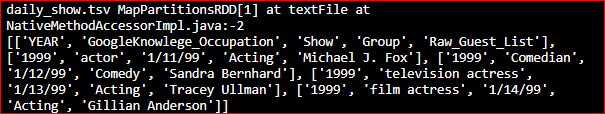

One of the wonderful features of PySpark is the ability to separate our logic - which we prefer to write in Python - from the actual data transformation. In above cell, we wrote this lambda function in Python code:

**raw_data.map(lambda line: line.split('\t'))**

Even though the function was in Python, we also took advantage of Scala when Spark actually ran the code over our RDD. This is the power of PySpark. Without learning any Scala, we get to harness the data processing performance gains from Spark's Scala architecture. Even better, when we ran the following code, it returned the results to us in Python-friendly notation:

**daily_show.take(5)**

**Transformations and Actions**

There are two types of methods in Spark:

1. Transformations - map(), reduceByKey()
2. Actions - take(), reduce(), saveAsTextFile(), collect()

Transformations are lazy operations that always return a reference to an RDD object. Spark doesn't actually run the transformations, though, until an action needs to use the RDD resulting from a transformation. Any function that returns an RDD is a transformation, and any function that returns a value is an action. These concepts will become more clear as we work through this lesson and practice writing PySpark code.

**Immutability**

We may be wondering why we couldn't just split each string in place, instead of creating a new object daily_show. In Python, we could have modified the collection element-by-element in place, without returning and assigning the results to a new object.

RDD objects are [immutable](https://www.quora.com/Why-is-RDD-immutable-in-Spark), meaning that we can't change their values once we've created them. In Python, list and dictionary objects are mutable (we can change their values), while tuple objects are immutable. The only way to modify a tuple object in Python is to create a new tuple object with the necessary updates. Spark uses the immutability of RDDs to enhance calculation speeds.

We'd like to tally up the number of guests who have appeared on The Daily Show during each year. If daily_show were a list of lists, we could write the following Python code to achieve this result:

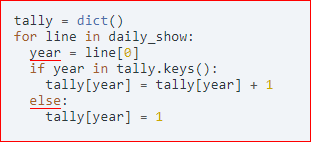

The keys in tally will be the years, and the values will be the totals for the number of lines associated with each year.

To achieve the same result with Spark, we'll have to use a Map step, then a ReduceByKey step.

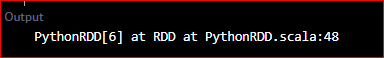

We may have noticed that printing tally didn't return the histogram we were hoping for. Because of lazy evaluation, PySpark delayed executing the map and reduceByKey steps until we actually need them. Before we use **take()** to preview the first few elements in tally, we'll walk through the code we just wrote.

**daily_show.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x+y)**

During the map step, we used a lambda function to create a tuple consisting of:

* key: x[0] (the first value in the list)
* value: 1 (the integer)

Our high-level strategy was to create a tuple with the key representing the year, and the value representing 1. After running the map step, Spark will maintain in memory a list of tuples resembling the following:

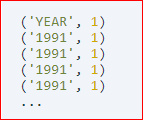

We'd like to reduce that down to:

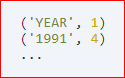

reduceByKey(f) combines tuples with the same key using the function we specify, f.

To see the results of these two steps, we'll use the take command, which forces lazy code to run immediately. Because tally is an RDD, we can't use Python's len function to find out how many elements are in the collection. Instead, we'll need to use the RDD count() function.

tally.take(tally.count())

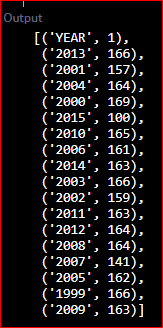

Unlike pandas, Spark knows nothing about column headers, and didn't set them aside. We need a way to remove the element ('YEAR', 1) from our collection. We'll need a workaround, though, because RDD objects are immutable once we create them. The only way to remove that tuple is to create a new RDD object that doesn't have it.

Spark comes with a filter(f) function that creates a new RDD by filtering an existing one for specific criteria. If we specify a function f that returns a binary value, True or False, the resulting RDD will consist of elements where the function evaluated to True. We can read more about the filter function in the [Spark documentation](https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html#filter).

Write a function named filter_year that we can use to filter out the element that begins with the text YEAR, instead of an actual year.

In [2]:
def filter_year(line):
    if line[0] == 'YEAR':
        return False
    else:
        return True

filtered_daily_show = daily_show.filter(lambda line: filter_year(line))

To flex Spark's muscles, we'll demonstrate how to chain together a series of data transformations into a pipeline, and observe Spark managing everything in the background. The developers who wrote Spark had this functionality in mind, and optimized it for running tasks in succession.

Before Spark came along, running lots of tasks in succession in Hadoop was incredibly time consuming. Hadoop had to write intermediate results to disk, and wasn't aware of the full pipeline. Thanks to its aggressive approach to memory use and well-architected core, Spark improves on Hadoop's turnaround time significantly. If we're curious, we can read more about this topic in a [Quora thread](http://qr.ae/RHWrT2).

In the following code cell, we'll filter out actors for whom the profession is blank, lowercase each profession, generate a histogram of professions, and output the first five tuples in the histogram.

\ is used to continue code in new line

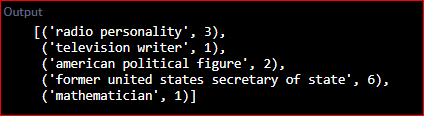

In this file, we introduced the MapReduce paradigm, the fundamentals of Spark, and PySpark data transformations.